In [28]:
import stellgap as sg
import numpy as np

In [4]:
stellgap_results = sg.AlfvenSpecData.from_dir('.')

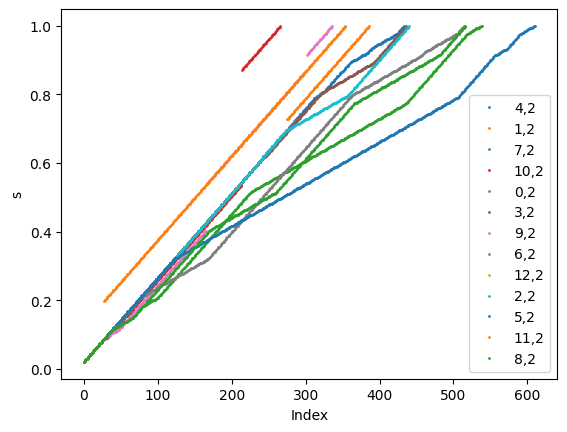

In [504]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(13):
    plt.plot(modes[i].s, label=f'{modes[i].m},{modes[i].n}', marker='o', linestyle='none', markersize=1)


plt.xlabel("Index")
plt.ylabel("s")
plt.legend()
plt.show()



13

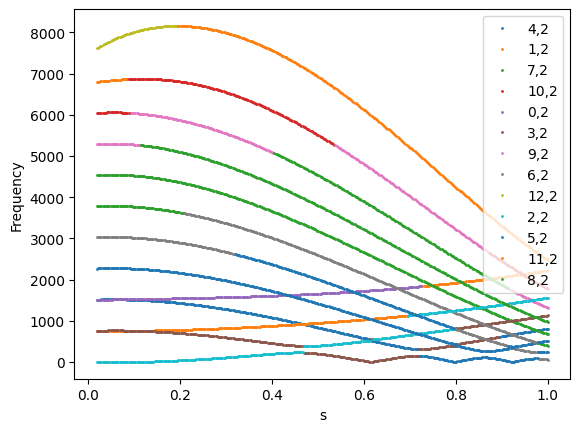

In [475]:
import matplotlib.pyplot as plt

modes = stellgap_results.get_modes()


plt.figure()
for i in range(13):
    plt.plot(modes[i].s,  modes[i].freq,  marker='o', linestyle='none', markersize=1, label=f'{modes[i].m},{modes[i].n}') 

plt.xlabel("s")
plt.ylabel("Frequency")
plt.legend()         
plt.show()


/var/folders/p2/77rb325x4tnbgkwpvctjj7mm0000gn/T/ipykernel_30368/105443002.py:91: RankWarning: Polyfit may be poorly conditioned
  segments = piecewise_polynomial_fit(modes[2], degree=50, jump_thresh=25.0)
/var/folders/p2/77rb325x4tnbgkwpvctjj7mm0000gn/T/ipykernel_30368/105443002.py:91: RankWarning: Polyfit may be poorly conditioned
  segments = piecewise_polynomial_fit(modes[2], degree=50, jump_thresh=25.0)
/var/folders/p2/77rb325x4tnbgkwpvctjj7mm0000gn/T/ipykernel_30368/105443002.py:91: RankWarning: Polyfit may be poorly conditioned
  segments = piecewise_polynomial_fit(modes[2], degree=50, jump_thresh=25.0)
/var/folders/p2/77rb325x4tnbgkwpvctjj7mm0000gn/T/ipykernel_30368/105443002.py:91: RankWarning: Polyfit may be poorly conditioned
  segments = piecewise_polynomial_fit(modes[2], degree=50, jump_thresh=25.0)
/var/folders/p2/77rb325x4tnbgkwpvctjj7mm0000gn/T/ipykernel_30368/105443002.py:91: RankWarning: Polyfit may be poorly conditioned
  segments = piecewise_polynomial_fit(modes[2],

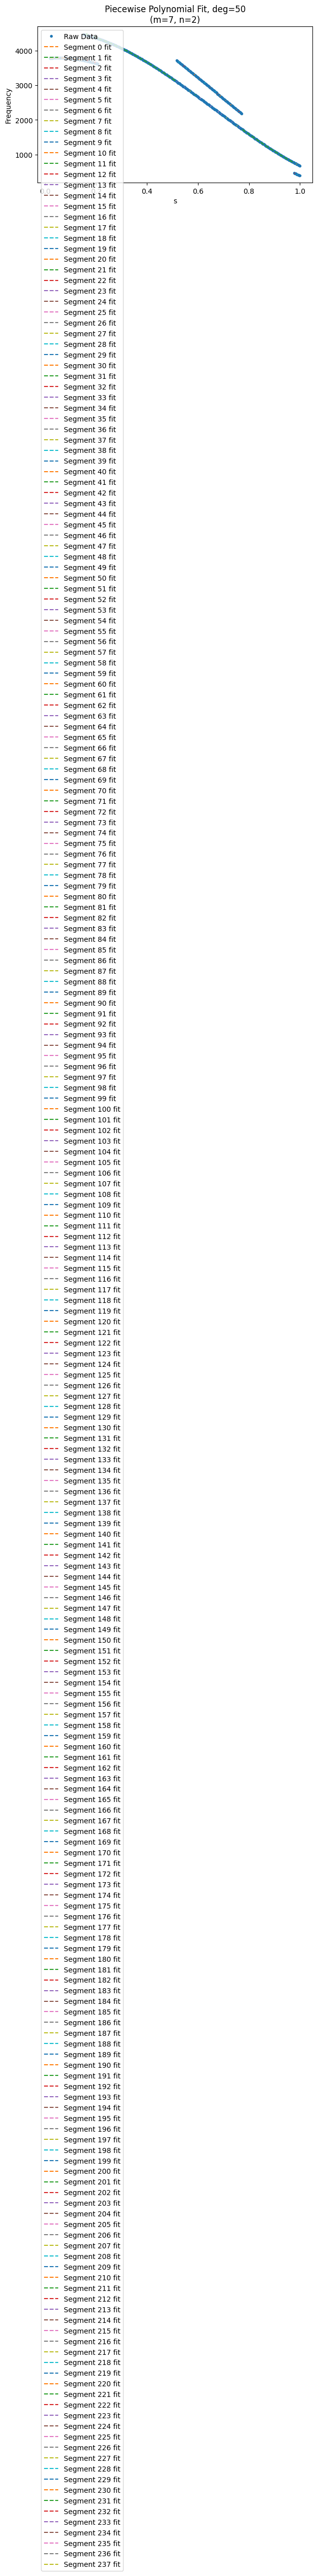

In [520]:
import numpy as np
import matplotlib.pyplot as plt

def piecewise_polynomial_fit(mode, degree=4, jump_thresh=100.0):
    """
    Fits multiple polynomials to a single mode's (s,freq) data,
    splitting into segments wherever there is a large jump.
    
    Parameters
    ----------
    mode : object with
        - mode.s    : array of s-values
        - mode.freq : array of freq-values
    degree : int
        The polynomial degree for each piecewise segment.
    jump_thresh : float
        A threshold for detecting "big jumps" in freq between adjacent points.
        Adjust based on your data scale.
    
    Returns
    -------
    segments : list of dicts, each dict has:
        - 's_vals': array of s in the segment
        - 'freq_vals': array of freq in the segment
        - 'poly_fn': np.poly1d object for the fitted polynomial
        - 'coeffs': polynomial coefficients
    """
    # 1) Convert to NumPy arrays and sort by s
    s_vals = np.array(mode.s)
    f_vals = np.array(mode.freq)
    idx_sort = np.argsort(s_vals)
    s_sorted = s_vals[idx_sort]
    f_sorted = f_vals[idx_sort]
    
    # 2) Identify segments by scanning for large jumps
    segments_boundaries = [0]  # start index of each segment
    for i in range(len(s_sorted) - 1):
        freq_jump = abs(f_sorted[i+1] - f_sorted[i])
        if freq_jump > jump_thresh:
            # Start a new segment after i
            segments_boundaries.append(i+1)
    # Finally, add the end boundary
    segments_boundaries.append(len(s_sorted))
    
    # 3) Fit each segment separately
    segments = []
    for seg_idx in range(len(segments_boundaries) - 1):
        start = segments_boundaries[seg_idx]
        end   = segments_boundaries[seg_idx+1]
        
        s_seg = s_sorted[start:end]
        f_seg = f_sorted[start:end]
        
        # Fit a polynomial on this segment
        coeffs = np.polyfit(s_seg, f_seg, deg=degree)
        poly_fn = np.poly1d(coeffs)
        
        segments.append({
            's_vals': s_seg,
            'freq_vals': f_seg,
            'coeffs': coeffs,
            'poly_fn': poly_fn
        })
    
    # 4) Plot each segment with its piecewise fit
    plt.figure(figsize=(7,4))
    plt.plot(s_sorted, f_sorted, 'o', markersize=3, label="Raw Data")
    
    for i, seg in enumerate(segments):
        s_seg = seg['s_vals']
        f_seg = seg['freq_vals']
        poly_fn = seg['poly_fn']
        
        # Evaluate the polynomial on a finer grid for plotting
        s_fit = np.linspace(s_seg.min(), s_seg.max(), 100)
        f_fit = poly_fn(s_fit)
        
        plt.plot(s_fit, f_fit, '--', label=f"Segment {i} fit")
    
    plt.xlabel("s")
    plt.ylabel("Frequency")
    plt.title(f"Piecewise Polynomial Fit, deg={degree}\n(m={mode.m}, n={mode.n})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return segments



segments = piecewise_polynomial_fit(modes[2], degree=50, jump_thresh=25.0)



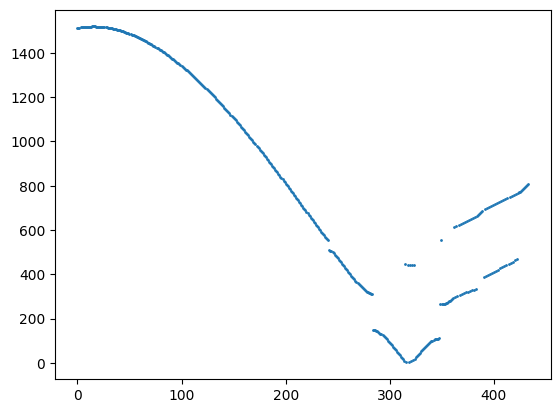

In [478]:
plt.plot(modes[0].freq, marker='o', linestyle='none', markersize=1,)

In [271]:
def heatmapMaker(modes):

    maxarraysizefinder = np.zeros(len(modes), dtype=float)
    for i in range(len(modes)):
        maxarraysizefinder[i] = modes[i].s.size
    maxArraySize = int(max(maxarraysizefinder)) # finds max array size of all modes


    maxfreqfinder = np.zeros(len(modes), dtype = float)
    for i in range(len(modes)):
        maxfreqfinder[i] = max(modes[i].freq) # finds max frequency of all modes
    maxFreq = max(maxfreqfinder)

    modePadder = np.zeros(len(modes), dtype = object)
    for i in range(len(modes)):
        modePadder[i] = np.pad(modes[i].freq, (0, maxArraySize - modes[i].freq.size), mode = 'constant', constant_values=0) # pads the end of smaller arrays with 0


    new_modes = np.zeros(len(modes), dtype = object)
    for i in range(len(modes)):
        new_modes[i] = [modePadder[i] / maxFreq, (modes[i].m,modes[i].n)] 

    M = np.zeros((maxArraySize,maxArraySize), dtype = float)
    for j in range(len(modes)):
        for i in range(maxArraySize):
            row_idx = int(new_modes[j][0][i] * (maxArraySize - 1))
            print(new_modes[j][0][i])
            M[row_idx, i] = 1
    return M

# scan left to right, noting swaps and intersections    

0.1854623212328478
0.18555942917529053
0.18565059633686282
0.18573576938348746
0.18581485801772088
0.1858880607681213
0.18595486518926338
0.18601522558356
0.1860688190469435
0.18611544610881167
0.18615506561753678
0.18618768738321714
0.18621343148333763
0.18623229475873027
0.1862442836999816
0.18624945682518704
0.1862477869699159
0.18623939626023236
0.1862244426220914
0.1862035944606358
0.18618047782972644
0.1861211229464678
0.1860857804146474
0.18603804974383212
0.1859825029793871
0.18591977803662446
0.18585031672077898
0.18577397411604316
0.185691092653571
0.18560162721997403
0.18550565026049057
0.18540314353127285
0.18529417474989468
0.18517867341471447
0.1850567173972877
0.1849283079330438
0.1847935624127143
0.1846525004607069
0.18450510982015267
0.18435143197661072
0.18419159072915595
0.18402555614978522
0.1838532538023226
0.18367489663821832
0.18349038131380693
0.1832997551280821
0.1831030599550689
0.18290042571595083
0.1826917142353832
0.18247712056607776
0.18225659297679878
0.1

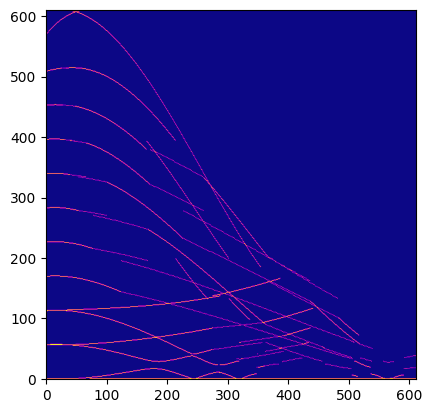

In [272]:
heatmap = heatmapMaker(modes)  # This returns a 2D numpy array
plt.imshow(heatmap, cmap='plasma', origin='lower')
plt.show()

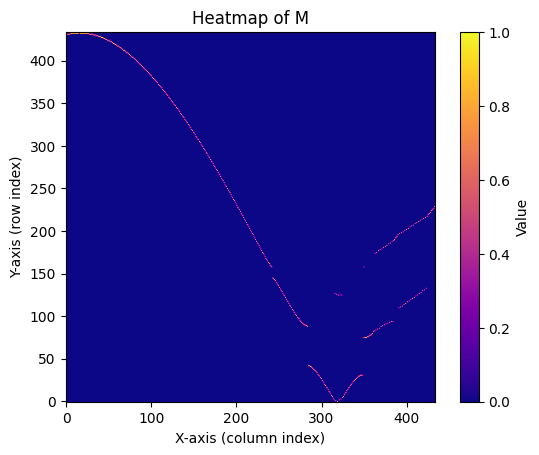

In [128]:

# normalize the y-values to be between 0 and 1
x = first_mode.s
y = first_mode.freq / max(first_mode.freq)

import numpy as np
n = x.size

M1 = np.zeros((n, n), dtype=float)

for i in range(n):
    # y[i] is in [0,1]
    # Map y[i] to an integer row index in [0, n-1]
    row_idx = int(y[i] * (n - 1))
    M1[row_idx, i] = 1



plt.imshow(M1, cmap='plasma', origin='lower')
plt.colorbar(label='Value')
plt.title("Heatmap of M")
plt.xlabel("X-axis (column index)")
plt.ylabel("Y-axis (row index)")
plt.show()


In [16]:
eleventh_mode_2d = np.column_stack((eleventh_mode.s))

In [30]:
def jump_detector(graph):
    graph_slopes = np.zeros(graph.size - 1)
    for s in range(graph.size - 1):
        graph_slopes[s] = graph[s+1] - graph[s]
    mean_slopes = graph_slopes.mean()
    std_slopes  = graph_slopes.std()
    return [mean_slopes, std_slopes, graph_slopes]

def branch_detector(graph):
    
    

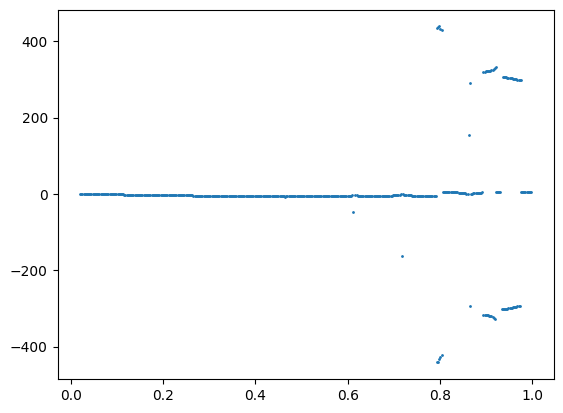

In [481]:
plt.plot(first_mode.s[:-1], jump_detector(first_mode.freq)[2], marker='o', linestyle='none', markersize=1)

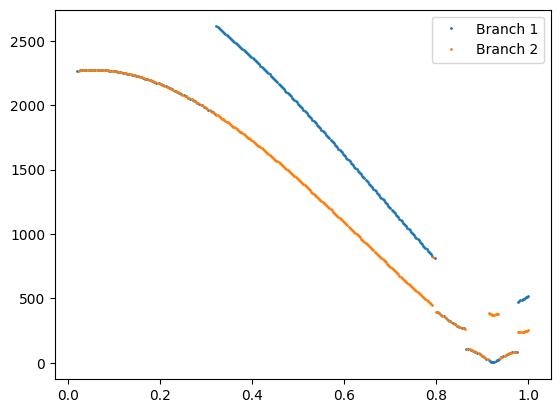

In [89]:
arr = eleventh_mode.freq

# Step 1: make an x array from 0..1 (or whatever range is appropriate)
x = eleventh_mode.s

# Step 2: split on even/odd indices
x_even = x[::2]
y_even = arr[::2]

x_odd = x[1::2]
y_odd = arr[1::2]

# Step 3: plot the two "branches" separately
plt.plot(x_even, y_even, marker='o', linestyle='none', markersize=1, label="Branch 1")
plt.plot(x_odd,  y_odd,  marker='o', linestyle='none', markersize=1, label="Branch 2")

plt.legend()
plt.show()

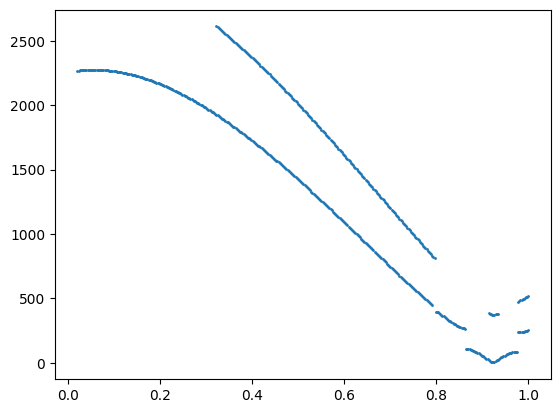

In [74]:
eleventh_mode.freqplt.plot(eleventh_mode.s, , marker='o', linestyle='none', markersize=1)


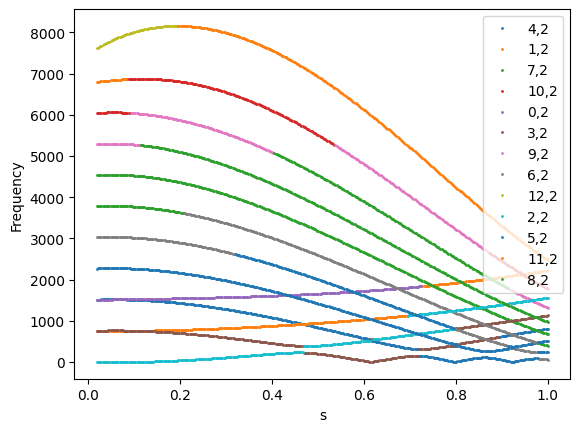

In [474]:
import matplotlib.pyplot as plt

modes = stellgap_results.get_modes()

mode0  = modes[0]
mode1  = modes[1]
mode2  = modes[2]
mode3  = modes[3]
mode4  = modes[4]
mode5  = modes[5]
mode6  = modes[6]
mode7  = modes[7]
mode8  = modes[8]
mode9  = modes[9]
mode10 = modes[10]
mode11 = modes[11]
mode12 = modes[12]

plt.figure()
for i in range(13):
    plt.plot(modes[i].s,  modes[i].freq,  marker='o', linestyle='none', markersize=1, label=f'{modes[i].m},{modes[i].n}') 

plt.xlabel("s")
plt.ylabel("Frequency")
plt.legend()         
plt.show()


In [3]:
sg.plot_continuum(
    stellgap_results.get_modes()
)

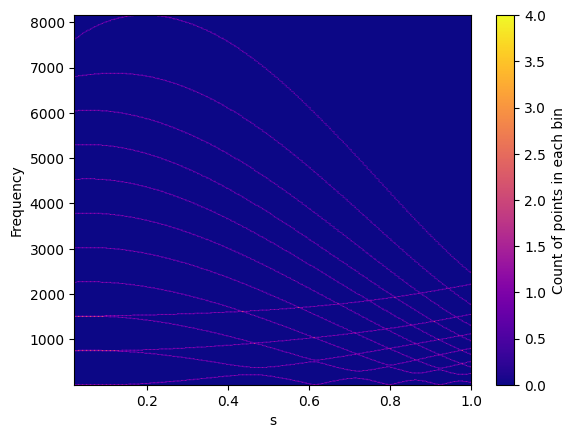

array([[2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

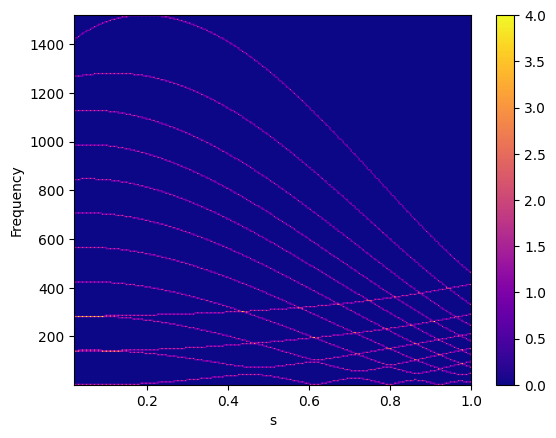

In [585]:
import numpy as np
import matplotlib.pyplot as plt

def all_modes_2d_mn(modes, nbins_s, nbins_f):
    
    s_vals_all = np.concatenate([m.s for m in modes])
    f_vals_all = np.concatenate([m.freq for m in modes])
    s_min, s_max = s_vals_all.min(), s_vals_all.max()
    f_min, f_max = f_vals_all.min(), f_vals_all.max()

    # standard 2D histogram for counts
    heatmap, s_edges, f_edges = np.histogram2d(
        s_vals_all,
        f_vals_all,
        bins=[nbins_s, nbins_f],
        range=[[s_min, s_max], [f_min, f_max]]
    )

    # create a 2D array of shape (nbins_s, nbins_f), dtype=object.
    # each cell is initially an array [0, 0].
    mn_array = np.empty((nbins_s, nbins_f), dtype=object)
    for i in range(nbins_s):
        for j in range(nbins_f):
            mn_array[i, j] = np.array([0, 0], dtype=int)

    # fill mn_array with [m, n] for the last mode's point that lands in each bin
    for mode in modes:
        for s_pt, f_pt in zip(mode.s, mode.freq):
            bin_s = np.searchsorted(s_edges, s_pt) - 1
            bin_f = np.searchsorted(f_edges, f_pt) - 1
            if 0 <= bin_s < nbins_s and 0 <= bin_f < nbins_f:
                mn_array[bin_s, bin_f] = np.array([mode.m, mode.n], dtype=int)
    return heatmap, s_edges, f_edges, mn_array


#
plt.imshow(
    all_modes_2d_mn(modes, nbins_s=300, nbins_f=300)[0].T,
    origin='lower',
    extent=[s_edges[0], s_edges[-1], f_edges[0], f_edges[-1]],
    aspect='auto',
    cmap='plasma'
)
plt.colorbar()
plt.xlabel('s')
plt.ylabel('Frequency')
plt.show()

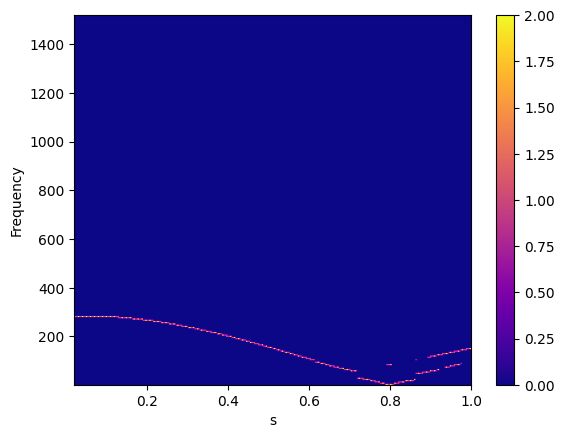

In [589]:
import numpy as np

def one_modes_2d_mn(modes, nbins_s, nbins_f, mode_number):
    """
    Builds a 2D histogram for only one mode (mode_number),
    but uses the global min/max from *all* modes so the bins
    remain consistent across all modes.
    """

    s_vals_global = np.concatenate([m.s for m in modes])
    f_vals_global = np.concatenate([m.freq for m in modes])
    
    s_min, s_max = s_vals_global.min(), s_vals_global.max()
    f_min, f_max = f_vals_global.min(), f_vals_global.max()


    mode = modes[mode_number]
    s_vals_all = np.array(mode.s)
    f_vals_all = np.array(mode.freq)


    heatmap, s_edges, f_edges = np.histogram2d(
        s_vals_all,
        f_vals_all,
        bins=[nbins_s, nbins_f],
        range=[[s_min, s_max], [f_min, f_max]]
    )


    mn_array = np.empty((nbins_s, nbins_f), dtype=object)
    for i in range(nbins_s):
        for j in range(nbins_f):
            mn_array[i, j] = np.array([0, 0], dtype=int)

    for s_pt, f_pt in zip(mode.s, mode.freq):
        bin_s = np.searchsorted(s_edges, s_pt) - 1
        bin_f = np.searchsorted(f_edges, f_pt) - 1
        if 0 <= bin_s < nbins_s and 0 <= bin_f < nbins_f:
            mn_array[bin_s, bin_f] = np.array([mode.m, mode.n], dtype=int)

    return heatmap, s_edges, f_edges, mn_array




plt.imshow(
    one_modes_2d_mn(modes, nbins_s=300, nbins_f=300, mode_number=0)[0].T,
    origin='lower',
    extent=[s_edges[0], s_edges[-1], f_edges[0], f_edges[-1]],
    aspect='auto',
    cmap='plasma'
)
plt.colorbar()
plt.xlabel('s')
plt.ylabel('Frequency')
plt.show()

In [705]:
q=300
p = 6
modes_heatmap = all_modes_2d_mn(modes, nbins_s=q, nbins_f=q)[0].T
oneModesNumbers_heatmap = one_modes_2d_mn(modes, nbins_s=q, nbins_f=q, mode_number=p)[3].T
modesNumbers_heatmap = all_modes_2d_mn(modes, nbins_s=q, nbins_f=q)[3].T

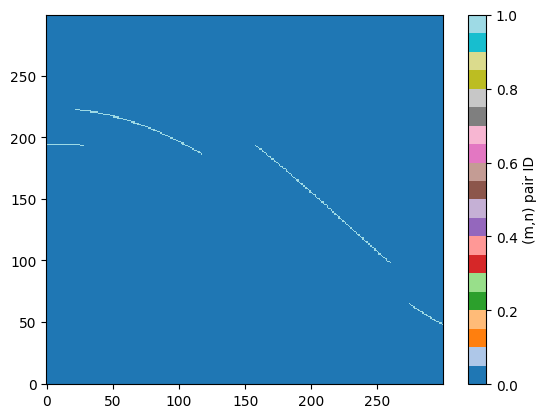

In [706]:
pairID_array = pair_mn_to_ids(oneModesNumbers_heatmap)

plt.figure()
plt.imshow(
    pairID_array,
    origin="lower",
    interpolation="none",
    cmap='tab20',
    aspect='auto'
)
plt.colorbar(label="(m,n) pair ID")



plt.show()

In [599]:
oneModesNumbers_heatmap_storage = np.empty(len(modes), dtype=object)

for i in range(len(modes)):
    oneModesNumbers_heatmap_storage[i] = one_modes_2d_mn(modes, nbins_s=q, nbins_f=q, mode_number=i)[3].T


***** starting a chain with array[0] as the initial array *****
=== starting chain in storage[0] at (row=55, col=0). ===
walked array[0] => ended at (row=20, col=181), val=[4 2].

  ==> bridge from array[0] end at (row=20, col=181)
      to array[5] at (row=20, col=181). Δm=-1, Δn=0

walked array[5] => ended at (row=20, col=182), val=[3 2].

  ==> bridge from array[5] end at (row=20, col=182)
      to array[9] at (row=20, col=183). Δm=-1, Δn=0

walked array[9] => ended at (row=29, col=237), val=[2 2].

  ==> bridge from array[9] end at (row=29, col=237)
      to array[5] at (row=29, col=238). Δm=1, Δn=0

walked array[5] => ended at (row=41, col=299), val=[3 2].

no bridging found after array[5].

***** end of chain for array 0 *****


***** starting a chain with array[1] as the initial array *****
=== starting chain in storage[1] at (row=27, col=0). ===
walked array[1] => ended at (row=41, col=206), val=[1 2].

  ==> bridge from array[1] end at (row=41, col=206)
      to array[9] at (

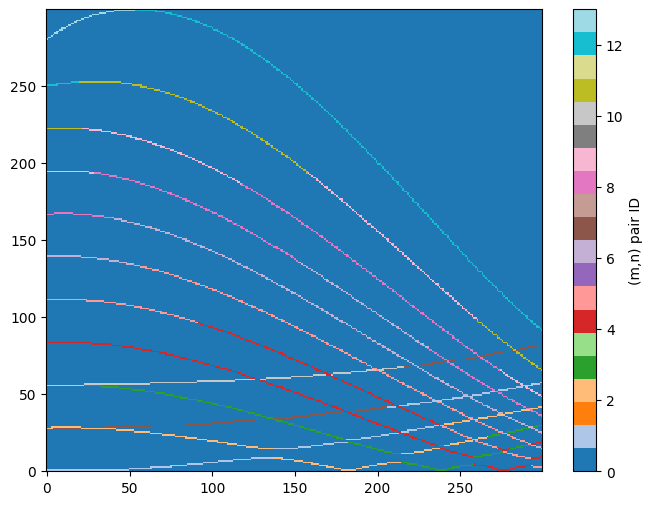

In [700]:
import numpy as np

def walk_single_array_path(arr, start_row, start_col, adjacency_radius=1):
    """
    Walk a single 2D array 'arr' from (start_row, start_col) to the right, picking exactly one row in each next column.
    
    Allow a move from (r,c) to (r_new, c+1) if:
      1) |r_new - r| <= adjacency_radius,
      2) arr[r_new, c+1] != [0,0].
    Among multiple valid r_new, pick the one closest to r (tie-break by smallest r_new).
    
    Returns a list of (row, col, arr[row,col]) from start to where we can't continue.
    """
    rows, cols = arr.shape
    
    def valid_nonzero(rr, cc):
        return (0 <= rr < rows and 0 <= cc < cols
                and not np.array_equal(arr[rr, cc], [0,0]))
    
    if not valid_nonzero(start_row, start_col):
        return []
    
    path = []
    cur_r = start_row
    cur_c = start_col
    path.append((cur_r, cur_c, arr[cur_r, cur_c]))
    
    while cur_c < cols - 1:
        next_c = cur_c + 1
        candidates = []
        for rr in range(cur_r - adjacency_radius, cur_r + adjacency_radius + 1):
            if valid_nonzero(rr, next_c):
                candidates.append(rr)
        
        if not candidates:
            break
        
        # picks the row that is closest to cur_r (tie-break by row index)
        best_r = min(candidates, key=lambda x: (abs(x - cur_r), x))
        cur_r = best_r
        cur_c = next_c
        path.append((cur_r, cur_c, arr[cur_r, cur_c]))
    
    return path

def find_bridge_two_column_options(storage,current_array_index, end_row, end_col, end_value, adjacency_radius=1):
    """
    Searches every array in `storage` except the current_array_index
    for a cell (r_new, c_new) with:
      - c_new == end_col  OR  c_new == end_col+1
      - |r_new - end_row| <= adjacency_radius
      - arr[r_new, c_new] != [0,0]
    
    Returns (new_array_index, r_new, c_new, val_new, dm, dn) or None if not found.
    We compute dm = val_new[0] - end_value[0], dn = val_new[1] - end_value[1].
    """
    n_arrays = storage.size
    possible_cols = [end_col, end_col + 1]
    
    for j in range(n_arrays):
        if j == current_array_index:
            continue
        
        arr_j = storage[j]
        rows_j, cols_j = arr_j.shape
        
        for c_new in possible_cols:
            if 0 <= c_new < cols_j:
                r_min = max(0, end_row - adjacency_radius)
                r_max = min(rows_j - 1, end_row + adjacency_radius)
                
                for r_new in range(r_min, r_max + 1):
                    val_new = arr_j[r_new, c_new]
                    if not np.array_equal(val_new, [0,0]):
                        dm = val_new[0] - end_value[0]
                        dn = val_new[1] - end_value[1]
                        return (j, r_new, c_new, val_new, dm, dn)
    
    return None

def walk_entire_storage_from(storage, start_array_index=0, adjacency_radius=1):
    """
    Perform the walk+bridge procedure STARTING from `storage[start_array_index]`, collecting all swaps in a list.

    Returns:
      A list 'swaps' of tuples describing each swap event:
        ( (old_i, old_r, old_c),
          (new_i, new_r, new_c),
          (dm, dn) )

    The function also prints the same info, but crucially, we return
    it so you can compile or plot them later.
    """
    swaps = []

    n_arrays = storage.size

    current_array_index = start_array_index
    arr = storage[current_array_index]
    rows, cols = arr.shape
    
    # find valid topmost row in col=0
    start_candidates = [r for r in range(rows)
                        if not np.array_equal(arr[r, 0], [0,0])]
    if not start_candidates:
        print(f"storage[{start_array_index}]: No non-zero in col=0 => can't start.")
        return swaps  # empty
    
    current_row = min(start_candidates)
    current_col = 0
    
    print(f"=== starting chain in storage[{current_array_index}] at (row={current_row}, col=0). ===")
    
    while True:
        arr = storage[current_array_index]
        
        # walk in this array from (current_row, current_col)
        path = walk_single_array_path(arr, current_row, current_col, adjacency_radius)
        if not path:
            print(f"no path found in storage[{current_array_index}] from (row={current_row}, col={current_col}). Done.")
            break
        
        end_r, end_c, end_val = path[-1]
        print(f"walked array[{current_array_index}] => ended at (row={end_r}, col={end_c}), val={end_val}.\n")
        
        # bridging
        bridge = find_bridge_two_column_options(storage, current_array_index, end_r, end_c, end_val, adjacency_radius)
        if bridge is None:
            print(f"no bridging found after array[{current_array_index}].\n")
            break
        
        (next_i, r_new, c_new, val_new, dm, dn) = bridge
        print(f"  ==> bridge from array[{current_array_index}] end at (row={end_r}, col={end_c})")
        print(f"      to array[{next_i}] at (row={r_new}, col={c_new}). Δm={dm}, Δn={dn}\n")
        
        swaps.append((
            (current_array_index, end_r, end_c),
            (next_i, r_new, c_new),              
            (dm, dn)                             
        ))
        
        
        current_array_index = next_i
        current_row = r_new
        current_col = c_new  


    return swaps

def walk_all_arrays_in_storage(storage, adjacency_radius=1):
    """
    For each array i in storage, run the chain logic starting from storage[i].
    Returns a single list 'all_swaps' containing the swap datafrom all chains. Each entry is 

      ( (old_i, old_r, old_c), (new_i, new_r, new_c), (dm, dn) ).
    """
    n_arrays = storage.size
    all_swaps = []
    

    
    for i in range(n_arrays):
        print(f"\n***** starting a chain with array[{i}] as the initial array *****")
        chain_swaps = walk_entire_storage_from(storage, start_array_index=i, adjacency_radius=adjacency_radius)
        print("***** end of chain for array", i, "*****\n")
        
        all_swaps.extend(chain_swaps)
    
    return all_swaps

all_swap_events = walk_all_arrays_in_storage(oneModesNumbers_heatmap_storage, adjacency_radius=1)

print("collected swap events:")
for event in all_swap_events:
    ((old_i, old_r, old_c), (new_i, new_r, new_c), (dm, dn)) = event
    print(f"swap from array[{old_i}], (r={old_r}, c={old_c}) -> array[{new_i}], (r={new_r}, c={new_c}), Δm={dm}, Δn={dn}")


def compile_swap_locations_for_array(all_swap_events, array_index):
    """
    Returns a list of (row, col, dm, dn) for each swap that occurred in 'array_index' (meaning the old array in the swap event).
    """
    swap_locations = []
    for ((old_i, old_r, old_c), (new_i, new_r, new_c), (dm, dn)) in all_swap_events:
        swap_locations.append((old_r, old_c, dm, dn))
    return swap_locations

import numpy as np
import matplotlib.pyplot as plt

pairID_array = pair_mn_to_ids(modesNumbers_heatmap)

plt.figure(figsize=(8,6))
plt.imshow(
    pairID_array,
    origin="lower",
    interpolation="none",
    cmap='tab20',
    aspect='auto'
)
plt.colorbar(label="(m,n) pair ID")


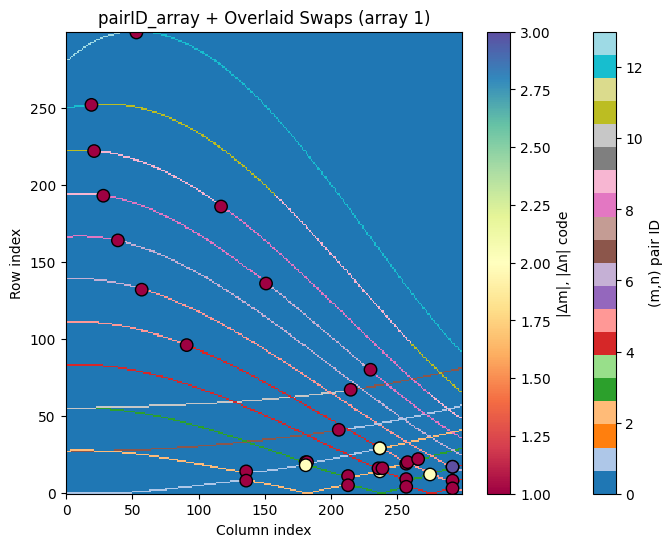

In [669]:
#this is just a plotter. I used GPT cause i didnt know how to overlay multiple graphs.



# 1) Suppose you already ran:
# all_swap_events = walk_all_arrays_in_storage(oneModesNumbers_heatmap_storage, adjacency_radius=1)
# and you have that list in memory.

# 2) Pick the array index you want to overlay swaps on:
MY_ARRAY_INDEX = 1

# 3) Compile all swap locations from old array = MY_ARRAY_INDEX
swap_points = compile_swap_locations_for_array(all_swap_events, MY_ARRAY_INDEX)
# This is now a list of (row, col, dm, dn).

# 4) Create a color code based on the absolute values of (dm, dn).
abs_pair_to_code = {}
swap_codes = []
next_code = 1

for (r, c, dm, dn) in swap_points:
    key = (abs(dm), abs(dn))
    if key not in abs_pair_to_code:
        abs_pair_to_code[key] = next_code
        next_code += 1
    swap_codes.append(abs_pair_to_code[key])

# 5) We want to scatter: x=col, y=row
x_positions = [c for (r,c,dm,dn) in swap_points]
y_positions = [r for (r,c,dm,dn) in swap_points]

sc = plt.scatter(
    x_positions,
    y_positions,
    c=swap_codes,
    cmap='Spectral', 
    s=80,
    edgecolors='black'
)
plt.colorbar(sc, label="|Δm|, |Δn| code")

plt.title(f"pairID_array + Overlaid Swaps (array {MY_ARRAY_INDEX})")
plt.xlabel("Column index")
plt.ylabel("Row index")

plt.show()


In [689]:
import scipy.ndimage as ndi
from collections import Counter


def label_zero_components(pairID_array):
    # no idea how this works, copied from online dont ask
    zero_mask = (pairID_array == 0)
    structure = ndi.generate_binary_structure(2, 1)
    labeled_zero, num_labels = ndi.label(zero_mask, structure=structure)
    return labeled_zero, num_labels


def spanning_void_components(labeled_zero, num_labels):
    rows, cols = labeled_zero.shape
    min_col = np.full(num_labels+1, cols, dtype=int)
    max_col = np.full(num_labels+1, -1, dtype=int)

    # find min_col/max_col for each region
    for r in range(rows):
        for c in range(cols):
            lab = labeled_zero[r,c]
            if lab > 0:
                if c < min_col[lab]:
                    min_col[lab] = c
                if c > max_col[lab]:
                    max_col[lab] = c
    
    # keeps the ones with min_col=0, max_col=cols-1
    spanning_labels = []
    for lab in range(1, num_labels+1):
        if min_col[lab] == 0 and max_col[lab] == (cols - 1):
            spanning_labels.append(lab)
    
    return spanning_labels


def enclosed_by_modes(pairID_array, labeled_zero, label):
    rows, cols = pairID_array.shape
    coords = np.argwhere(labeled_zero == label)
    if coords.size == 0:
        return False

    # ind min_r, max_r for each column c
    col_minmax = {}
    for (r,c) in coords:
        if c not in col_minmax:
            col_minmax[c] = [r, r]  # [min_r, max_r]
        else:
            if r < col_minmax[c][0]: col_minmax[c][0] = r
            if r > col_minmax[c][1]: col_minmax[c][1] = r

    # in each clmn, check if there exists a mode above and below max_r and min_r 
    for c, (min_r, max_r) in col_minmax.items():
        has_above = False
        for rr in range(min_r-1, -1, -1):
            if pairID_array[rr, c] != 0:
                has_above = True
                break
        has_below = False
        for rr in range(max_r+1, rows):
            if pairID_array[rr, c] != 0:
                has_below = True
                break
        if not (has_above and has_below):
            return False
    
    return True


def gather_swap_type_counts_for_region(labeled_zero, label, swap_dict, diagonal=False):
    """
    For the void region 'label' in 'labeled_zero', 
    look at the neighboring cells for any key in swap_dict.
    
    swap_dict: dict {(r,c): swap_type}, 
               e.g. swap_type = (abs_dm, abs_dn).
    diagonal:  bool, whether to consider diagonal neighbors.

    Returns a Counter (dict-like) of {swap_type: count}, 
    counting how many (r,c) neighbors had that swap_type.
    """
    rows, cols = labeled_zero.shape
    coords = np.argwhere(labeled_zero == label)

    # Decide connectivity
    if diagonal:
        neigh_offsets = [(-1,0),(1,0),(0,-1),(0,1),
                         (-1,-1),(-1,1),(1,-1),(1,1)]
    else:
        neigh_offsets = [(-1,0),(1,0),(0,-1),(0,1)]
    
    freq_counter = Counter()

    for (r,c) in coords:
        for (dr,dc) in neigh_offsets:
            rr, cc = r+dr, c+dc
            # Make sure we are in-bounds
            if 0 <= rr < rows and 0 <= cc < cols:
                if (rr, cc) in swap_dict:
                    # This neighbor has a known swap
                    swap_type = swap_dict[(rr, cc)]
                    freq_counter[swap_type] += 1
    
    return freq_counter


def filter_gaps_by_dominant_swap_type(labeled_zero, gap_labels, swap_dict, threshold=0.5):
    """
    For each gap label in 'gap_labels', we gather the frequency counts 
    of all swap types it touches. If one type's frequency >= threshold * total,
    we label it as the "dominant" swap type.

    Returns a dict: { label: dominant_swap_type, ... } 
    for those that pass. 
    If multiple types tie for dominance, we pick whichever first meets the threshold.
    """
    valid_gaps = {}
    for lab in gap_labels:
        freq_counter = gather_swap_type_counts_for_region(labeled_zero, lab, swap_dict, diagonal=False)
        total_swaps_touched = sum(freq_counter.values())  # sum of all frequencies
        
        if total_swaps_touched == 0:
            # This gap doesn't touch any swaps => skip
            continue
        
        # Check each type's frequency
        for swap_type, count in freq_counter.items():
            proportion = count / total_swaps_touched
            if proportion >= threshold:
                # We found a dominant type
                valid_gaps[lab] = swap_type
                break  # no need to check others, we pick the first that meets threshold
    
    return valid_gaps

labeled_zero, gap_labels = detect_gap_candidates(pairID_array)
dominant_dict = filter_gaps_by_dominant_swap_type(labeled_zero, gap_labels, swap_dict, threshold=0.5)


def detect_gap_candidates(pairID_array):

    labeled, num_labels = label_zero_components(pairID_array)
    spanning = spanning_void_components(labeled, num_labels)
    gap_labels = []
    for lab in spanning:
        if enclosed_by_modes(pairID_array, labeled, lab):
            gap_labels.append(lab)
    return labeled, gap_labels



labeled_zero, gap_labels = detect_gap_candidates(pairID_array)

#print("\nlabeled zero array:\n", labeled_zero)
#print("\ngap labels found:", gap_labels)
#if gap_labels:
#    print("zero-components, span left->right and enclosed.")
#else:
#    print("no enclosed gaps found.")


In [684]:
def process_gaps_with_threshold(pairID_array, swap_dict, threshold=0.5):
    """
    1) Detect candidate gaps with detect_gap_candidates
    2) Among them, pick only those with a dominant swap type 
       that meets 'threshold' proportion.
    """
    labeled_zero, gap_labels = detect_gap_candidates(pairID_array)

    dominant_dict = filter_gaps_by_dominant_swap_type(
        labeled_zero, gap_labels, swap_dict, threshold=threshold
    )
    return labeled_zero, dominant_dict




In [707]:
swap_dict = {}

for ((old_i, old_r, old_c), (new_i, new_r, new_c), (dm, dn)) in all_swap_events:

    abs_dm = abs(dm)
    abs_dn = abs(dn)
    
    swap_dict[(new_r, new_c)] = (abs_dm, abs_dn)


def gather_swap_types_for_region(labeled_zero, label, swap_dict, diagonal=False):
    """
    For the void region 'label' in 'labeled_zero', 
    look at the neighboring cells for swap events.
    
    swap_dict: dict {(r,c): swap_type} 
               e.g. swap_type could be (abs(dm), abs(dn)) or a unique ID.
    diagonal:  whether to consider diagonal neighbors.

    Returns: set of swap_types that this gap region touches.
    """
    rows, cols = labeled_zero.shape
    coords = np.argwhere(labeled_zero == label)
    if diagonal:
        neigh_offsets = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    else:
        neigh_offsets = [(-1,0),(1,0),(0,-1),(0,1)]
    
    swap_types_found = set()
    for (r,c) in coords:
        for (dr,dc) in neigh_offsets:
            rr, cc = r+dr, c+dc
            if (rr, cc) in swap_dict:
                # this region touches a swap event at (rr, cc)
                swap_types_found.add(swap_dict[(rr, cc)])
    return swap_types_found


def filter_gaps_by_swap_type(labeled_zero, gap_labels, swap_dict):
    """
    For each gap label in 'gap_labels', see which swap types it touches
    by checking neighbors in 'swap_dict'. 
    Keep only those that touch exactly 1 swap type.
    
    Returns a dict: { label: that_single_swap_type } or similar structure.
    """
    valid_gaps = {}
    for lab in gap_labels:
        swap_types = gather_swap_types_for_region(labeled_zero, lab, swap_dict, diagonal=False)
        if len(swap_types) == 1:
            (swap_type,) = swap_types
            valid_gaps[lab] = swap_type
    return valid_gaps

def process_gaps(pairID_array, swap_dict):
    """
    1) Detect candidate gap labels using the existing logic.
    2) keep only the ones that touch exactly one swap type.
    3) Return a dictionary mapping label -> that single swap type.
    """
    labeled_zero, gap_labels = detect_gap_candidates(pairID_array)
    
    valid_gap_dict = filter_gaps_by_swap_type(labeled_zero, gap_labels, swap_dict)
    
    return labeled_zero, valid_gap_dict




(labeled_zero, final_gaps) = process_gaps_with_threshold(pairID_array, swap_dict, 0.5); print("gaps:", final_gaps, "\nlabels array:\n", labeled_zero)


gaps: {} 
labels array:
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


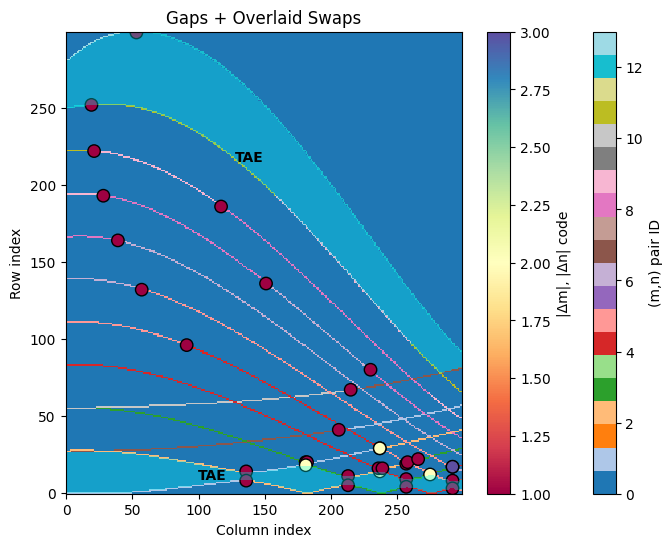

In [697]:


def classify_swap(abs_dm, abs_dn):
    if abs_dm == 0 and abs_dn == 0:
        return "GAE"
    elif abs_dm == 1 and abs_dn == 0:
        return "TAE"
    elif abs_dm == 2 and abs_dn == 0:
        return "EAE"
    elif abs_dm >= 3 and abs_dn == 0:
        return "NAE"
    elif abs_dm == 0 and abs_dn >= 1:
        return "MAE"
    else:
        return "HAE"

classification_colors = {
    "GAE": "lime",
    "TAE": "cyan",
    "EAE": "yellow",
    "NAE": "magenta",
    "MAE": "blue",
    "HAE": "red",
}

def plot_gaps_on_top(labeled_zero, dominant_dict, classification_colors):
    rows, cols = labeled_zero.shape
    for gap_label, (abs_dm, abs_dn) in dominant_dict.items():
        # Classify
        class_name = classify_swap(abs_dm, abs_dn)
        color = classification_colors.get(class_name, "white")

        # Mask for this gap_label
        mask = (labeled_zero == gap_label)

        # Fill the region with contourf
        plt.contourf(
            mask.astype(float),
            levels=[0.5,1],
            colors=[color],
            alpha=0.3
        )

        # Centroid
        coords = np.argwhere(mask)
        if coords.size > 0:
            mean_r = coords[:,0].mean()
            mean_c = coords[:,1].mean()
            plt.text(
                mean_c, mean_r,
                class_name,
                color="k",
                ha="center", va="center",
                fontsize=10, fontweight="bold"
            )

plt.figure(figsize=(8,6))
plt.imshow(
    pairID_array,
    origin="lower",
    interpolation="none",
    cmap='tab20',
    aspect='auto'
)
plt.colorbar(label="(m,n) pair ID")

x_positions = [c for (r,c,dm,dn) in swap_points]
y_positions = [r for (r,c,dm,dn) in swap_points]
abs_swap_codes = []
abs_pair_to_code = {}
code_counter = 1
for (r, c, dm, dn) in swap_points:
    key = (abs(dm), abs(dn))
    if key not in abs_pair_to_code:
        abs_pair_to_code[key] = code_counter
        code_counter += 1
    abs_swap_codes.append(abs_pair_to_code[key])

sc = plt.scatter(
    x_positions,
    y_positions,
    c=abs_swap_codes,
    cmap='Spectral',
    s=80,
    edgecolors='black'
)
plt.colorbar(sc, label="|Δm|, |Δn| code")

plt.title(f"Gaps + Overlaid Swaps")
plt.xlabel("Column index")
plt.ylabel("Row index")


plot_gaps_on_top(labeled_zero, dominant_dict, classification_colors)

plt.show()


In [639]:
import numpy as np
#working version but now i need for every element in storage
def walk_single_array_path(arr, start_row, start_col, adjacency_radius=1):
    """
    Walks a SINGLE path to the right in 'arr' from (start_row, start_col).

    Rules:
      - Each cell arr[r,c] is array([m,n]) or [0,0].
      - We consider a cell "non-zero" if != [0,0].
      - From (r,c) -> (r_new, c+1) is allowed if:
           (i) |r_new - r| <= adjacency_radius
          (ii) arr[r_new, c+1] != [0,0]
      - Among multiple (r_new) candidates, pick the one with minimal
        distance to 'r' (tie-break by smallest r_new).

    Returns:
      path = list of (row, col, value) for each visited cell,
             from the start up to where we can't continue or the last column.
      If (start_row, start_col) is invalid (i.e. [0,0] or out of bounds),
      returns an empty list.
    """
    rows, cols = arr.shape
    
    def in_bounds_nonzero(rr, cc):
        return (0 <= rr < rows and 0 <= cc < cols
                and not np.array_equal(arr[rr, cc], [0,0]))
    
    # If we can't even start, return empty
    if not in_bounds_nonzero(start_row, start_col):
        return []
    
    path = []
    cur_r = start_row
    cur_c = start_col
    path.append((cur_r, cur_c, arr[cur_r, cur_c]))
    
    # Move right until we can't
    while cur_c < cols - 1:
        next_c = cur_c + 1
        candidates = []
        for rr in range(cur_r - adjacency_radius, cur_r + adjacency_radius + 1):
            if in_bounds_nonzero(rr, next_c):
                candidates.append(rr)
        
        if not candidates:
            # no valid move
            break
        
        # among candidates, pick the row closest to cur_r (tie-break by smaller row)
        best_r = min(candidates, key=lambda x: (abs(x - cur_r), x))
        
        cur_r = best_r
        cur_c = next_c
        path.append((cur_r, cur_c, arr[cur_r, cur_c]))
    
    return path

def find_bridge_two_column_options(storage,
                                   current_array_index,
                                   end_row, end_col, end_value,
                                   adjacency_radius=1):
    """
    Look for a bridging cell in ANY other array in 'storage'.

    A bridging cell is (r_new, c_new, val_new) with:
      1. c_new == end_col  OR  c_new == end_col + 1
      2. |r_new - end_row| <= adjacency_radius
      3. val_new != [0,0]

    Returns:
      (new_array_index, r_new, c_new, val_new) + (dm, dn)
    or None if no bridging was found.

    If multiple arrays match, returns the first found. 
    If you want to pick a certain array or row first, you might sort or filter.
    """
    n_arrays = storage.size
    
    # Candidate columns:
    possible_cols = [end_col, end_col + 1]

    for j in range(n_arrays):
        # skip bridging to the same array if that's not desired
        if j == current_array_index:
            continue
        
        arr_j = storage[j]
        rows_j, cols_j = arr_j.shape
        
        for c_new in possible_cols:
            if 0 <= c_new < cols_j:
                # check row adjacency
                r_min = max(0, end_row - adjacency_radius)
                r_max = min(rows_j - 1, end_row + adjacency_radius)
                
                for r_new in range(r_min, r_max + 1):
                    val_new = arr_j[r_new, c_new]
                    if not np.array_equal(val_new, [0,0]):
                        # We found a bridging cell
                        dm = val_new[0] - end_value[0]
                        dn = val_new[1] - end_value[1]
                        return (j, r_new, c_new, val_new, dm, dn)
    
    # No match
    return None

def walk_entire_storage(storage, adjacency_radius=1):
    """
    Overall procedure:
      - We'll start in storage[0], col=0 at the topmost non-zero row.
      - Walk to the right (single path) using row adjacency within that array.
      - At the end, try bridging to any other array in the same col or col+1, 
        with row adjacency. If found, print swap info (Δm, Δn, old row/col).
      - Then continue from that bridging cell in the new array.
      - Repeat until no bridging is found.
    """
    n_arrays = storage.size

    current_array_index = 0
    arr = storage[current_array_index]
    rows, cols = arr.shape

    # 1) Find a valid starting row in col=0 (e.g., topmost non-zero)
    start_candidates = [r for r in range(rows) if not np.array_equal(arr[r, 0], [0,0])]
    if not start_candidates:
        print("storage[0]: No non-zero in col=0; cannot start.")
        return
    
    current_row = min(start_candidates)  # topmost
    current_col = 0
    
    print(f"=== Start in storage[{current_array_index}] at (row={current_row}, col=0). ===")

    while True:
        arr = storage[current_array_index]
        
        # 2) Walk in this array from (current_row, current_col) to the right
        path = walk_single_array_path(arr, current_row, current_col, adjacency_radius)
        if not path:
            print(f"No path found in storage[{current_array_index}] from (row={current_row}, col={current_col}). Done.")
            break
        
        # The last step in 'path' is our new end
        end_r, end_c, end_val = path[-1]
        print(f"Walked array[{current_array_index}] => ended at (row={end_r}, col={end_c}), val={end_val}.\n")
        
        # 3) Try bridging to ANY other array
        bridge = find_bridge_two_column_options(
            storage, 
            current_array_index,
            end_r, 
            end_c, 
            end_val,
            adjacency_radius
        )
        
        if bridge is None:
            print(f"No bridging found after array[{current_array_index}]. Done.\n")
            break
        
        (next_i, r_new, c_new, val_new, dm, dn) = bridge
        
        print(f"  ==> Bridge from array[{current_array_index}] end at (row={end_r}, col={end_c})")
        print(f"      to array[{next_i}] start at (row={r_new}, col={c_new}).")
        print(f"      Δm={dm}, Δn={dn}\n")
        
        # 4) Switch to the new array
        current_array_index = next_i
        current_row = r_new
        current_col = c_new  # We keep the bridging column
        # We'll loop back up and walk_single_array_path from here.

walk_entire_storage(oneModesNumbers_heatmap_storage, adjacency_radius=1)

=== Start in storage[0] at (row=55, col=0). ===
Walked array[0] => ended at (row=20, col=181), val=[4 2].

  ==> Bridge from array[0] end at (row=20, col=181)
      to array[5] start at (row=20, col=181).
      Δm=-1, Δn=0

Walked array[5] => ended at (row=20, col=182), val=[3 2].

  ==> Bridge from array[5] end at (row=20, col=182)
      to array[9] start at (row=20, col=183).
      Δm=-1, Δn=0

Walked array[9] => ended at (row=29, col=237), val=[2 2].

  ==> Bridge from array[9] end at (row=29, col=237)
      to array[5] start at (row=29, col=238).
      Δm=1, Δn=0

Walked array[5] => ended at (row=41, col=299), val=[3 2].

No bridging found after array[5]. Done.



In [625]:
import numpy as np
#first version
def to_mask(arr):
    """Return a boolean mask of the same shape as `arr` 
       where True indicates arr[r,c] != [0,0]."""
    rows, cols = arr.shape
    mask = np.zeros((rows, cols), dtype=bool)
    for r in range(rows):
        for c in range(cols):
            if not np.array_equal(arr[r, c], [0, 0]):
                mask[r, c] = True
    return mask

def swap_detector(storage):
    """
    For each 2D array in `storage`, we:
      1) Create a binary mask indicating which cells are nonzero ([0,0] vs. not).
      2) Choose a single 'start_row' in column 0 (topmost, bottommost, etc.).
      3) Propagate column by column. For each column c+1, the active rows are those
         that are within `adjacency_radius` of an active row in column c AND are nonzero.
      4) Stop when no rows remain active or we've reached the last column.
      5) Pick a single 'finish_row' from the final active set (again, topmost, bottommost, etc.).
      6) Print the start and finish row indices for each 2D array.
    """
    adjacency_radius = 1  # how many rows up or down we can jump to remain "touching"
    
    for i in range(storage.size):
        arr = storage[i]
        
        # Check for a valid 2D array
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            print(f"storage[{i}] is not a valid 2D array.")
            continue
        
        rows, cols = arr.shape
        if cols == 0:
            print(f"storage[{i}]: Array has no columns.")
            continue
        
        # 1) Convert array to a boolean mask: True = nonzero, False = zero ([0,0])
        mask = to_mask(arr)
        
        # 2) Find all nonzero rows in the first column
        first_col_nonzero_rows = [r for r in range(rows) if mask[r, 0]]
        
        if not first_col_nonzero_rows:
            print(f"storage[{i}]: No non-zero elements in the first column.")
            continue
        
        # Pick a single start row.
        # For topmost, use min(...); for bottommost, use max(...).
        start_row = min(first_col_nonzero_rows)  # topmost
        # start_row = max(first_col_nonzero_rows)  # bottommost (if desired)
        
        print(f"storage[{i}]: start row index = {start_row}, col=0")
        
        # Current set of active rows in column 0 is just the single start row
        active_rows = {start_row}
        last_col = 0
        
        # 3) Move column-by-column, updating active_rows
        for c in range(1, cols):
            new_active_rows = set()
            
            # Find candidate rows in column c that are nonzero
            candidate_rows = [r for r in range(rows) if mask[r, c]]
            
            for r in candidate_rows:
                # If r is within adjacency_radius of any row in active_rows, it's connected
                for old_r in active_rows:
                    if abs(r - old_r) <= adjacency_radius:
                        new_active_rows.add(r)
                        break  # No need to check more old_r once we know r is active
            
            if not new_active_rows:
                # No connectivity to this column
                break
            
            active_rows = new_active_rows
            last_col = c
        
        # 4) Determine a single finish row
        # If multiple rows remain active, pick topmost, bottommost, etc.
        if active_rows:
            finish_row = min(active_rows)  # topmost among the final set
            # finish_row = max(active_rows)  # bottommost, if that's what you want
            print(f"storage[{i}]: finish row index = {finish_row}, col={last_col}\n")
        else:
            # If active_rows is empty, we ended in the previous column
            # and there's no "final" row in last_col, so we just show
            # the column we ended on (i.e., last_col - 1).
            # But we might want to handle this edge case differently.
            print(f"storage[{i}]: Path ended before col={last_col}, no active rows remain.\n")

swap_detector(oneModesNumbers_heatmap_storage)    

storage[0]: start row index = 55, col=0
storage[0]: finish row index = 20, col=181

storage[1]: start row index = 27, col=0
storage[1]: finish row index = 41, col=206

storage[2]: start row index = 139, col=0
storage[2]: finish row index = 132, col=57

storage[3]: start row index = 222, col=0
storage[3]: finish row index = 222, col=21

storage[4]: start row index = 55, col=0
storage[4]: finish row index = 67, col=215

storage[5]: start row index = 27, col=0
storage[5]: finish row index = 14, col=136

storage[6]: start row index = 194, col=0
storage[6]: finish row index = 193, col=28

storage[7]: start row index = 111, col=0
storage[7]: finish row index = 96, col=91

storage[8]: start row index = 280, col=0
storage[8]: finish row index = 299, col=53

storage[9]: start row index = 0, col=0
storage[9]: finish row index = 8, col=136

storage[10]: start row index = 83, col=0
storage[10]: finish row index = 16, col=236

storage[11]: start row index = 250, col=0
storage[11]: finish row index 

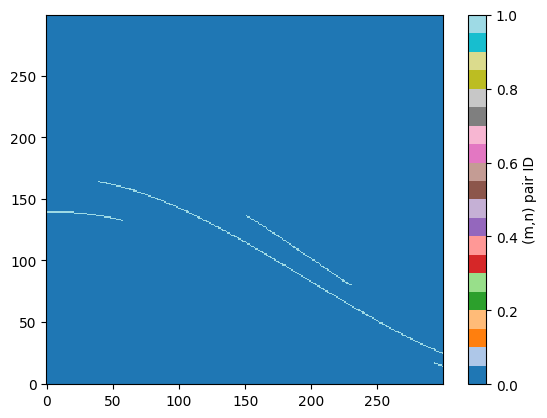

In [651]:
import numpy as np

def pair_mn_to_ids(modesNumbers_heatmap):
    """
    modesNumbers_heatmap: 2D array of shape (rows, cols).
    Each cell is an array of length 2: [m, n], or [0, 0] if no mode.
    Return a 2D integer array 'pairID_array' of the same shape,
    where each unique (m, n) (excluding [0,0]) is assigned a unique ID > 0,
    and [0,0] remains 0. To serve as a visual aid.
    """

    rows, cols = modesNumbers_heatmap.shape
    pairID_array = np.zeros((rows, cols), dtype=int)

    pair_to_id = {}
    current_id = 1

    for i in range(rows):
        for j in range(cols):
            pair = tuple(modesNumbers_heatmap[i, j])
            if pair != (0, 0):
                if pair not in pair_to_id:
                    pair_to_id[pair] = current_id
                    current_id += 1
                pairID_array[i, j] = pair_to_id[pair]

    return pairID_array




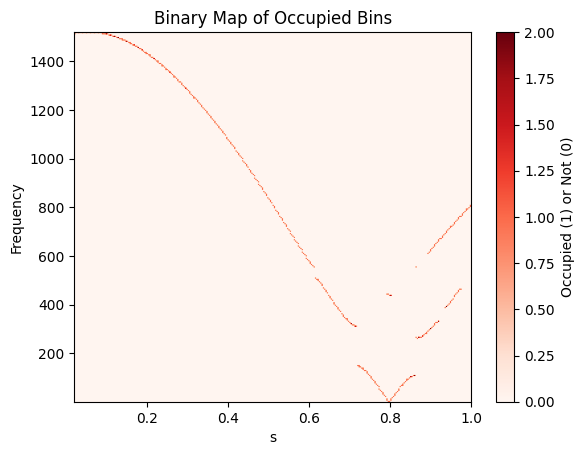

In [556]:
import numpy as np
import matplotlib.pyplot as plt

def all_modes_2d_mn2(modes, nbins_s, nbins_f, mode_index=0):
    """
    Computes a 2D histogram of (s, freq) for a single mode in 'modes'.
    Also builds an array 'mn_array' that stores [m, n] in each bin, using
    just that one mode's data.

    Parameters
    ----------
    modes : list
        A list of mode objects (e.g., modes[i].s, modes[i].freq, modes[i].m, modes[i].n).
    nbins_s : int
        Number of bins in the s-direction.
    nbins_f : int
        Number of bins in the frequency direction.
    mode_index : int
        Which mode (by index) to process from the 'modes' list. Default is 0.

    Returns
    -------
    heatmap : 2D numpy array
        The histogram counts of shape (nbins_s, nbins_f).
    s_edges : 1D array
        Bin edges in s.
    f_edges : 1D array
        Bin edges in freq.
    mn_array : 2D array of shape (nbins_s, nbins_f), dtype=object
        Each cell is [m, n] for the last point that lands in that bin (or [0,0] if none).
    """

    # -- Pick only ONE mode --
    mode = modes[mode_index]
    
    # Combine s, freq just for this single mode:
    s_vals_all = np.array(mode.s)
    f_vals_all = np.array(mode.freq)
    
    # Determine ranges
    s_min, s_max = s_vals_all.min(), s_vals_all.max()
    f_min, f_max = f_vals_all.min(), f_vals_all.max()

    # Standard 2D histogram for counts
    heatmap, s_edges, f_edges = np.histogram2d(
        s_vals_all,
        f_vals_all,
        bins=[nbins_s, nbins_f],
        range=[[s_min, s_max], [f_min, f_max]]
    )

    # Create a 2D array of shape (nbins_s, nbins_f), dtype=object.
    # Each cell initially [0, 0].
    mn_array = np.empty((nbins_s, nbins_f), dtype=object)
    for i in range(nbins_s):
        for j in range(nbins_f):
            mn_array[i, j] = np.array([0, 0], dtype=int)

    # Fill mn_array with [m, n] for each point that lands in the bin
    for s_pt, f_pt in zip(mode.s, mode.freq):
        bin_s = np.searchsorted(s_edges, s_pt) - 1
        bin_f = np.searchsorted(f_edges, f_pt) - 1
        if 0 <= bin_s < nbins_s and 0 <= bin_f < nbins_f:
            mn_array[bin_s, bin_f] = np.array([mode.m, mode.n], dtype=int)
    
    return heatmap, s_edges, f_edges, mn_array


def pair_mn_to_ids2(modesNumbers_heatmap):
    """
    modesNumbers_heatmap: 2D array of shape (rows, cols).
    Each cell is an array [m, n], or [0, 0] if no mode.
    Return a 2D integer array 'pairID_array' of same shape,
    where each unique (m, n) is assigned a unique ID > 0
    (except [0,0] remains 0).
    """
    rows, cols = modesNumbers_heatmap.shape
    pairID_array = np.zeros((rows, cols), dtype=int)

    pair_to_id = {}
    current_id = 1

    for i in range(rows):
        for j in range(cols):
            pair = tuple(modesNumbers_heatmap[i, j])
            if pair != (0, 0):
                if pair not in pair_to_id:
                    pair_to_id[pair] = current_id
                    current_id += 1
                pairID_array[i, j] = pair_to_id[pair]

    return pairID_array

# Example: bins in s and freq
nbins_s = 300
nbins_f = 300

# Choose which mode to process
chosen_mode_index = 0  # (e.g. 4 for the 5th mode in the list)

heatmap, s_edges, f_edges, mn_array = all_modes_2d_mn(
    modes,
    nbins_s=nbins_s,
    nbins_f=nbins_f,
    mode_index=chosen_mode_index
)

pairID_array2 = pair_mn_to_ids2(mn_array)


plt.figure()
plt.imshow(
    heatmap.T,
    origin='lower',
    aspect='auto',
    extent=[s_edges[0], s_edges[-1], f_edges[0], f_edges[-1]],
    cmap='Reds'  # or any colormap
)
plt.colorbar(label="Occupied (1) or Not (0)")
plt.xlabel("s")
plt.ylabel("Frequency")
plt.title("Binary Map of Occupied Bins")
plt.show()




In [471]:
import numpy as np

def detect_full_swaps(
    modesNumbers_heatmap,
    revert_threshold=6
):
    
    rows, cols = modesNumbers_heatmap.shape
    swaps = []

    for col in range(cols):
        for row in range(rows):
            curr_mn = modesNumbers_heatmap[row, col]
            if np.array_equal(curr_mn, [0, 0]):
                continue

            neighbors = []
            if row > 0:
                neighbors.append((row-1, col))
            if row < rows - 1:
                neighbors.append((row+1, col))

            if col + 1 < cols:
                neighbors.append((row, col + 1))
                if row > 0:
                    neighbors.append((row - 1, col + 1))
                if row < rows - 1:
                    neighbors.append((row + 1, col + 1))

            for (r_next, c_next) in neighbors:
                new_mn = modesNumbers_heatmap[r_next, c_next]
                if (not np.array_equal(new_mn, [0, 0]) and
                    not np.array_equal(new_mn, curr_mn)):

                    # found a potential swap from curr_mn -> new_mn
                    # check if it "reverts back" within revert_threshold columns
                    reverts_back = False

                    # only search further columns for revert
                    start_col = c_next
                    end_col = min(start_col + revert_threshold, cols)

                    for cc in range(start_col + 1, end_col):

                        # here let's just check the same (r_next, cc).
                        revert_mn = modesNumbers_heatmap[r_next, cc]
                        if np.array_equal(revert_mn, curr_mn):
                            reverts_back = True
                            break

                    if not reverts_back:
                        swaps.append({
                            "from": (row, col, curr_mn.copy()),
                            "to":   (r_next, c_next, new_mn.copy())
                        })

    return swaps

swaps = detect_full_swaps(modesNumbers_heatmap, revert_threshold=15)

# 'swaps' is a list of dictionaries, each describing one detected swap.
for swap in swaps:
    print("Swap from {} at {} to {} at {}"
          .format(swap["from"][2],   # [m_old, n_old]
                  (swap["from"][0], swap["from"][1]),   # (row, col)
                  swap["to"][2],     # [m_new, n_new]
                  (swap["to"][0], swap["to"][1])))       # (r_next, c_next)

Swap from [3 2] at (27, 3) to [1 2] at (27, 4)
Swap from [3 2] at (28, 3) to [1 2] at (27, 4)
Swap from [1 2] at (27, 4) to [3 2] at (28, 4)
Swap from [1 2] at (27, 4) to [3 2] at (28, 5)
Swap from [3 2] at (28, 4) to [1 2] at (27, 4)
Swap from [3 2] at (28, 4) to [1 2] at (27, 5)
Swap from [1 2] at (27, 5) to [3 2] at (28, 5)
Swap from [1 2] at (27, 5) to [3 2] at (28, 6)
Swap from [3 2] at (28, 5) to [1 2] at (27, 5)
Swap from [3 2] at (28, 5) to [1 2] at (27, 6)
Swap from [1 2] at (27, 6) to [3 2] at (28, 6)
Swap from [1 2] at (27, 6) to [3 2] at (28, 7)
Swap from [3 2] at (28, 6) to [1 2] at (27, 6)
Swap from [1 2] at (27, 7) to [3 2] at (28, 7)
Swap from [1 2] at (27, 7) to [3 2] at (28, 8)
Swap from [1 2] at (27, 8) to [3 2] at (28, 8)
Swap from [1 2] at (27, 8) to [3 2] at (28, 9)
Swap from [1 2] at (27, 9) to [3 2] at (28, 9)
Swap from [1 2] at (27, 9) to [3 2] at (28, 10)
Swap from [1 2] at (27, 10) to [3 2] at (28, 10)
Swap from [1 2] at (27, 10) to [3 2] at (28, 11)
Swap fro